This notebook focuses on validating the uncertainty estimator; applying a hypothesis test is left as a downstream application.

Throughout this notebook we adopt a frequentist perspective, validating uncertainty estimates via repeated sampling (Monte Carlo).

Importing the necessary libraries for the project

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import yaml
from tools import draw_rect_overlap, run_toys

with open("config.yaml", "r") as f:
    cfg = yaml.safe_load(f)

seed = cfg["seed"]
N = 1000
 
p = cfg["p_true"]
p_true = np.array([p["p11"], p["p10"], p["p01"], p["p00"]], dtype=float)
p11, p10, p01, p00 = p["p11"], p["p10"], p["p01"], p["p00"]
probabilities = [p11, p10, p01, p00]

print("Setup complete.")

Setup complete.


Let's create some dataset using *Monte Carlo toys*. 

We will generate $N=10^5$ events, that are pairs of $(A,B)$ where $A\in\{0,1\}$ or $B\in\{0,1\}$. 
The joint probability distribution is assumed to contain:

$$
P_{AB} = (p_{11},p_{10},p_{01},p_{00})
$$

Thus the "*truth*" efficiencies are:

$$\hat e_{A} = 0.60+0.20= 0.80 ~~, \hat e_{B} = 0.60 + 0.15 = 0.75$$



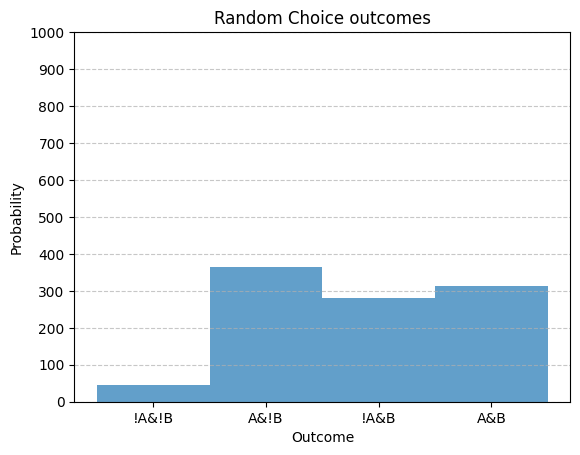

Simulation complete.
Outcomes distribution:
Eff(A) = 0.676
Eff(B) = 0.592


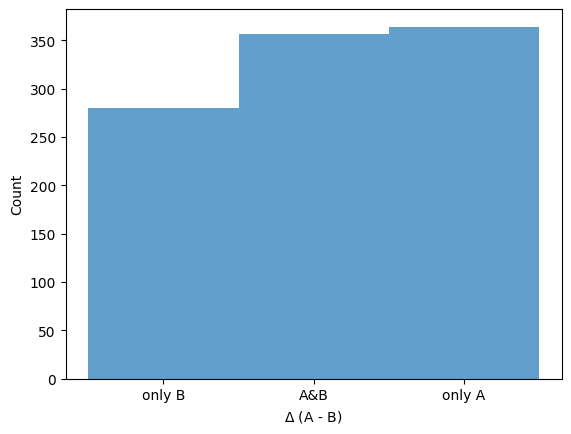

In [2]:

outcomes = ["A&B", "A&!B", "!A&B", "!A&!B"]

rnd_gen = np.random.default_rng(seed)

x = rnd_gen.choice(outcomes, size=N, p=probabilities)
plt.hist(x, bins=np.arange(5)-0.5, range=(0,4),  histtype='stepfilled', alpha=0.7)
plt.xlabel('Outcome')  
plt.ylabel('Probability')
plt.yticks(np.arange(0, N+1, step=100))
plt.grid(True, axis='y', which='major', linestyle='--', alpha=0.7)
plt.title('Random Choice outcomes') 
plt.show()

sample_A = (x == 'A&B') | (x == 'A&!B')
sample_B = (x == 'A&B') | (x == '!A&B')
sample_Delta = sample_A.astype(int) - sample_B.astype(int)

print("Simulation complete.")
print("Outcomes distribution:")
print(f"Eff(A) = {np.sum(sample_A) / N:.3f}")
print(f"Eff(B) = {np.sum(sample_B) / N:.3f}")
plt.hist(sample_Delta, bins=3, range=(-1,2), histtype='stepfilled', alpha=0.7)
plt.xticks([-0.5, 0.5, 1.5], ['only B', 'A&B', 'only A'])
plt.xlabel(fr'$\Delta$ (A - B)')
plt.ylabel('Count')
plt.show()

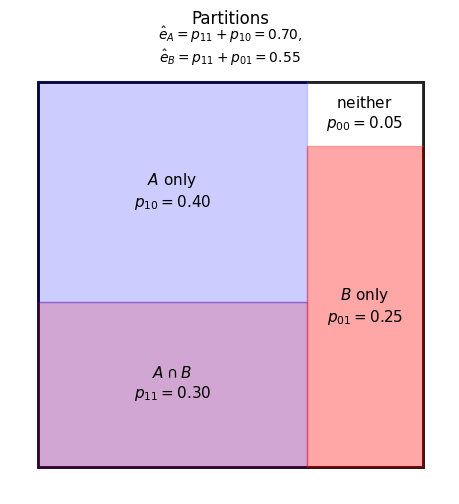

In [3]:
draw_rect_overlap(l=7, p11=p11, p10=p10, p01=p01, p00=p00,
                  title="Partitions")

The above set the concept. We will slightly change the code, performing the same task of sampling A,B events but after moving in a "Multinomial" formalism. This can improve the speed and efficiency of our code.

$$\{n_i\} \sim Multinomial ( N_{{events}} ; \{p_i\} ) , ~~ \{p_{i}\}\in R^4 $$

At each toy, we will assuming the efficiences $\hat e_{A},~\hat e_{B}$ to be independent Binomial variables:

$$\hat e_{A} \sim Binomial (N_{{events}}; e_{A})~~,~~\hat e_{B} \sim Binomial (N_{{events}}; e_{B})$$

To construct a "naive" Variance of the difference:

$$\sigma_{{Naive}}^2 = \dfrac{ e_{A} (1- e_{A})}{N_{{events}}}+\dfrac{ e_{B} (1-  e_{B})}{N_{{events}}} $$

And compare to a "correct" Variance:

$$\sigma_{{Correct}}^2 = \dfrac{n_{10}+n_{01}}{N_{{events}}^2}$$

for the large-$N_{{events}}$ limit (subleading terms can be neglected) yielding an asymptotically consistent estimator.



In [4]:

Nevents = 1000000
Ntoys = 10000000

deltas, sigma_corrs, sigma_naives, eff_A_array, eff_B_array = run_toys(
    Nevents, 
    Ntoys, 
    probabilities, 
    rnd_gen)
 
print("Toys complete. No. of toys:", Ntoys)



Toys complete. No. of toys: 10000000


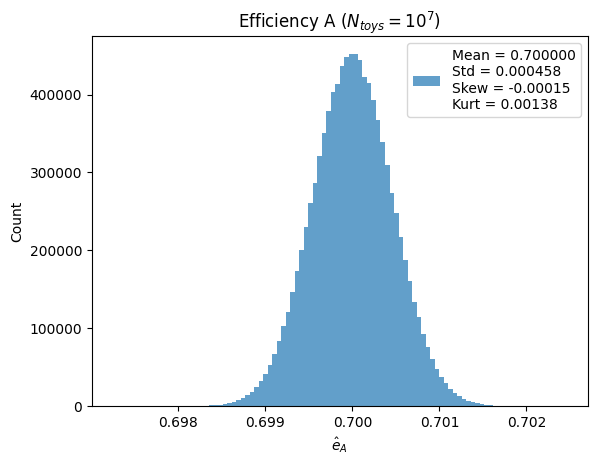

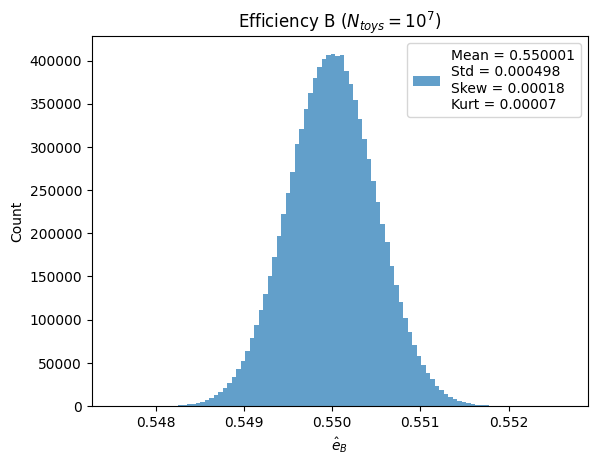

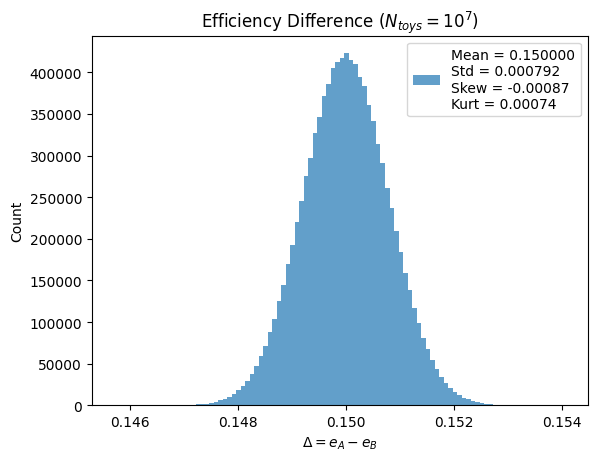

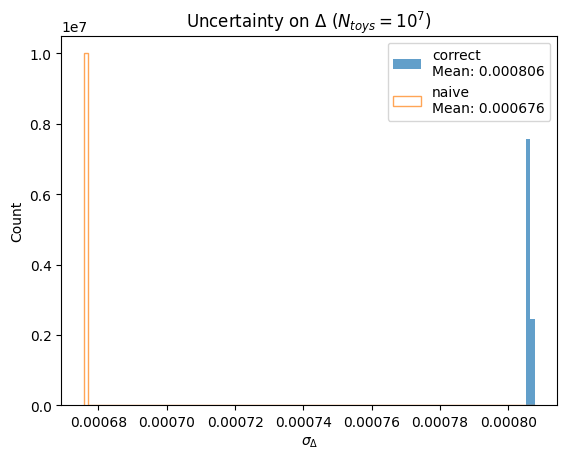

Toy simulations complete.
Mean Delta: 0.150000 ± 0.000792
Mean sigma_corr: 0.000806
Mean sigma_naive: 0.000676


In [5]:

resA , resB , resD, resSigCor, resSigNai = stats.describe(eff_A_array),stats.describe(eff_B_array), stats.describe(deltas), stats.describe(sigma_corrs), stats.describe(sigma_naives)   
label_A = (
    rf"Mean = {resA.mean:.6f}" "\n"
    rf"Std = {np.sqrt(resA.variance):.6f}" "\n"
    rf"Skew = {resA.skewness:.5f}" "\n"
    rf"Kurt = {resA.kurtosis:.5f}"
)

label_B = (
    rf"Mean = {resB.mean:.6f}" "\n"
    rf"Std = {np.sqrt(resB.variance):.6f}" "\n"
    rf"Skew = {resB.skewness:.5f}" "\n"
    rf"Kurt = {resB.kurtosis:.5f}"
)
label_D = (
    rf"Mean = {resD.mean:.6f}" "\n"
    rf"Std = {np.sqrt(resD.variance):.6f}" "\n"
    rf"Skew = {resD.skewness:.5f}" "\n"
    rf"Kurt = {resD.kurtosis:.5f}"
)


plt.hist(eff_A_array, bins=100, histtype='stepfilled', alpha=0.7, label=label_A)
plt.xlabel(r'$\hat{{e}}_A$ ')
plt.ylabel('Count')
plt.legend()
plt.title(rf'Efficiency A ($N_{{toys}}=10^{np.log10(Ntoys):.0f}$)')
plt.savefig('figures/effA_hist.png',format='png', dpi=150)
plt.show()

plt.hist(eff_B_array, bins=100, histtype='stepfilled', alpha=0.7, label=label_B)
plt.xlabel(r'$\hat{{e}}_B$ ')
plt.ylabel('Count')
plt.legend()
plt.title(rf'Efficiency B ($N_{{toys}}=10^{np.log10(Ntoys):.0f}$)')
plt.savefig('figures/effB_hist.png',format='png', dpi=150)
plt.show()

plt.hist(deltas, bins=100, histtype='stepfilled', alpha=0.7, label=label_D)
plt.xlabel(r'$\Delta = e_A - e_B$ ')
plt.ylabel('Count')
plt.legend()
plt.title(rf'Efficiency Difference ($N_{{toys}}=10^{np.log10(Ntoys):.0f}$)')
plt.savefig('figures/delta_hist.png',format='png', dpi=150)
plt.show()

min_val = min(np.min(sigma_corrs), np.min(sigma_naives))
max_val = max(np.max(sigma_corrs), np.max(sigma_naives))
# create 100 bins (101 edges) shared between both histograms
bins = np.linspace(min_val, max_val, 101)

 
plt.hist(sigma_corrs, bins=bins, label=f'correct\nMean: {resSigCor.mean:.6f}', histtype='stepfilled', alpha=0.7)
plt.hist(sigma_naives, bins=bins, label=f'naive\nMean: {resSigNai.mean:.6f}', histtype='step', alpha=0.7)
plt.xlabel(r'$\sigma_{\Delta}$')
plt.ylabel('Count')
plt.legend()
plt.title(rf'Uncertainty on $\Delta$ ($N_{{toys}}=10^{np.log10(Ntoys):.0f}$)')
plt.savefig('figures/sigma_hist.png',format='png', dpi=150)
plt.show()

print("Toy simulations complete.")
print(f"Mean Delta: {resD.mean:.6f} ± {np.sqrt(resD.variance):.6f}")
print(f"Mean sigma_corr: {resSigCor.mean:.6f}")
print(f"Mean sigma_naive: {resSigNai.mean:.6f}")

Finally produce pull plots to show better the deviation. We have for $e_{A} = p_{11} + p_{10}$ and $e_{B}=p_{11}+p_{01}$ :

$$
\Delta^{true} = e_{A} - e_{B} = p_{10} - p_{01} 
$$

and we define the pull:

$$
pull(Corr) = (\Delta_i - \Delta^{true}) /  \sigma_{corr,i}
$$


$$
pull(Naive) = (\Delta_i - \Delta^{true}) /  \sigma_{naive,i}
$$




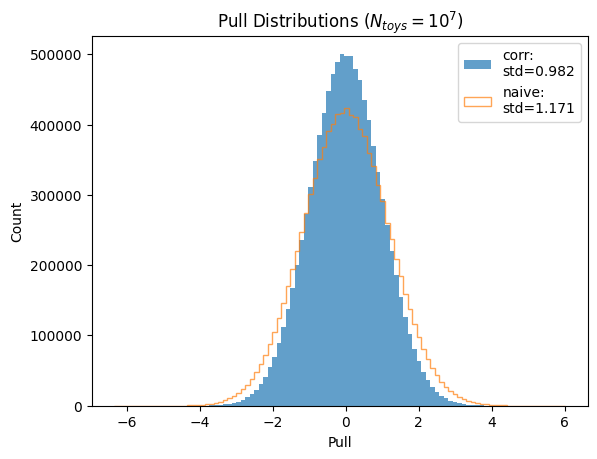

Pull distributions plotted.
Pull_corr: mean=-0.000606, std=0.982433
Pull_naive: mean=-0.000526, std=1.171020


In [6]:
pull_corr  = (deltas - (probabilities[1] - probabilities[2])) / sigma_corrs
pull_naive = (deltas - (probabilities[1] - probabilities[2])) / sigma_naives

min_val = min(np.min(pull_corr), np.min(pull_naive))
max_val = max(np.max(pull_corr), np.max(pull_naive))
# create 100 bins (101 edges) shared between both histograms
bins = np.linspace(min_val, max_val, 101)

plt.hist(pull_corr, bins=bins, label=f'corr:\nstd={np.std(pull_corr):.3f}', histtype='stepfilled', alpha=0.7)
plt.hist(pull_naive, bins=bins, label=f'naive:\nstd={np.std(pull_naive):.3f}', histtype='step', alpha=0.7)
plt.xlabel('Pull')
plt.ylabel('Count')
plt.title(rf'Pull Distributions ($N_{{toys}}=10^{np.log10(Ntoys):.0f}$)')
plt.legend()
plt.show()

print("Pull distributions plotted.")
print(f"Pull_corr: mean={np.mean(pull_corr):.6f}, std={np.std(pull_corr):.6f}")
print(f"Pull_naive: mean={np.mean(pull_naive):.6f}, std={np.std(pull_naive):.6f}") 

Also it is interesting to check when the naive method and the method that takes into account the correlations coincide. These cases are coincidental, meaning that the naive method is correct. However if someone chose values of probabilities close to them, they might wrongly reach the result that the two methods are identical. 

2.681750955026499e-06


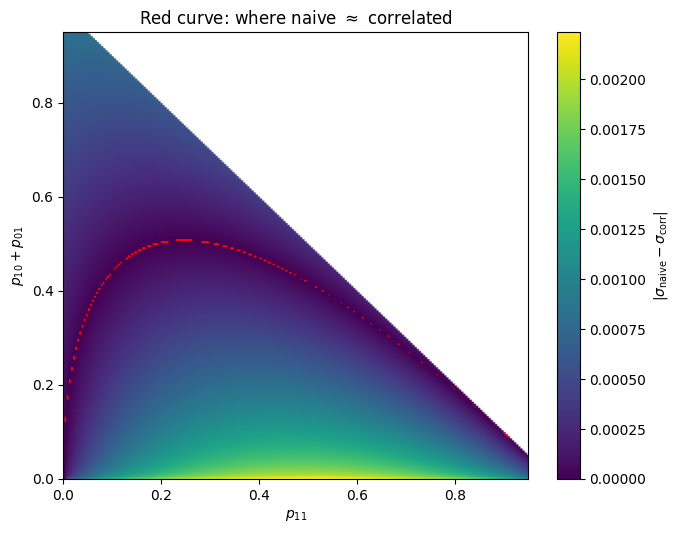

In [7]:

Nevents = 100000

# baseline disagreement split ratio
p10_base, p01_base = 0.4, 0.25
r = p10_base / (p10_base + p01_base)

# grid
p11_vals = np.linspace(0.0, 0.95, 220)   # will be masked where invalid
s_vals   = np.linspace(0.0, 0.95, 220)   # s = p10 + p01

P11, S = np.meshgrid(p11_vals, s_vals)

P10 = r * S
P01 = (1 - r) * S
P00 = 1.0 - P11 - S

# valid region: all probs >= 0
valid = (P00 >= 0) & (P10 >= 0) & (P01 >= 0) & (P11 >= 0)

# efficiencies
eA = P11 + P10
eB = P11 + P01

# exact correlated variance for Delta
d = P10 - P01
var_corr = (S - d**2) / Nevents  # Var(Delta)

# numerical safety
valid &= (var_corr >= 0) & (eA >= 0) & (eA <= 1) & (eB >= 0) & (eB <= 1)

sigma_corr  = np.full_like(P11, np.nan, dtype=float)
sigma_naive = np.full_like(P11, np.nan, dtype=float)

sigma_corr[valid] = np.sqrt(var_corr[valid])
sigma_naive[valid] = np.sqrt(eA[valid] * (1 - eA[valid]) / Nevents +
                             eB[valid] * (1 - eB[valid]) / Nevents)

# distance metric: relative difference
rel = np.abs(sigma_naive - sigma_corr)# / sigma_corr  # >0 naive bigger, <0 naive smaller

#0.000003
MIN = (np.nanmin(rel[rel>0]))*300
print(MIN)
# optional: contour where they match
plt.figure(figsize=(7.5, 5.8))
plt.contour(P11, S, rel, levels=[MIN], colors='r', linewidths=1.0)
plt.imshow(rel, origin='lower', aspect='auto',
           extent=[p11_vals.min(), p11_vals.max(), s_vals.min(), s_vals.max()])
plt.colorbar(label=r'$|\sigma_{\mathrm{naive}}-\sigma_{\mathrm{corr}}|$')#/\sigma_{\mathrm{corr}}$')
plt.xlabel(r'$p_{11}$')
plt.ylabel(r'$p_{10}+p_{01}$')
plt.title(r'Red curve: where naive $\approx$ correlated')
plt.show()


In [18]:
from matplotlib.animation import FuncAnimation

# --- params ---
N, FRAMES = 400, 250
p11, p10, p01, p00 = 0.70, 0.10, 0.05, 0.15
p = [p11, p10, p01, p00]
true_delta = p10 - p01
rng = np.random.default_rng(7)

# fixed event positions
xy = rng.random((N, 2))

# colors: 11 purple, 10 blue, 01 red, 00 faded grey
C = np.array([
    [0.55, 0.35, 0.75, 0.90],
    [0.20, 0.45, 0.90, 0.95],
    [0.90, 0.25, 0.25, 0.95],
    [0.75, 0.75, 0.75, 0.25],
])

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), gridspec_kw={"width_ratios":[1.2, 1]})
ax0.set(xlim=(0,1), ylim=(0,1), xticks=[], yticks=[], title="Events (A,B categories)")
ax1.set(xlim=(-0.35,0.35), title=r"Running $\Delta=(n_{10}-n_{01})/N$", xlabel=r"$\Delta$", ylabel="count")

sc = ax0.scatter(xy[:,0], xy[:,1], s=25, edgecolors="none")
info = ax0.text(0.02, 0.98, "", transform=ax0.transAxes, va="top",
                bbox=dict(facecolor="white", alpha=0.8, edgecolor="none"), family="monospace", fontsize=9)

bins = np.linspace(-0.35, 0.35, 41)
centers = 0.5*(bins[:-1] + bins[1:])
bars = ax1.bar(centers, np.zeros_like(centers), width=bins[1]-bins[0], align="center")
line_now = ax1.axvline(0, lw=2)
line_true = ax1.axvline(true_delta, lw=2, ls="--")

deltas = []

def update(_):
    cats = rng.choice(4, size=N, p=p)
    sc.set_facecolors(C[cats])

    n10 = np.sum(cats == 1)
    n01 = np.sum(cats == 2)
    d = (n10 - n01) / N
    deltas.append(d)

    # disagreement-only sigma (plug-in): sqrt(n10+n01)/N
    sig = np.sqrt(n10 + n01) / N
    info.set_text(f"n10={n10:3d}  n01={n01:3d}\nΔ={d: .4f}  σ≈{sig: .4f}")

    h, _ = np.histogram(deltas, bins=bins)
    for b, hh in zip(bars, h): b.set_height(hh)
    ax1.set_ylim(0, max(1, int(h.max()*1.15)))

    line_now.set_xdata([d, d])
    return (sc, info, *bars, line_now, line_true)

anim = FuncAnimation(fig, update, frames=FRAMES, interval=50, blit=False)
plt.tight_layout()
anim.save("figures/demo.gif", fps=20)
plt.show()


<IPython.core.display.Javascript object>

MovieWriter ffmpeg unavailable; using Pillow instead.
